In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import matplotlib.pyplot as plt

In [4]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import spearmanr
import matplotlib.pyplot as plt

from access_biology_data import meta, gwas_studies, relations
from access_literature_data import medline, wos
from access_science_shared import standardizer

from scipy.stats import wilcoxon

In [5]:
save_images = True
taxon_id = 9606

In [6]:
def export_image(file_name):
    outpath = '/Users/tstoeger/Dropbox/ratti/material/{}.pdf'.format(file_name)
    
    if save_images:
        plt.savefig(outpath, bbox_inches='tight')

In [7]:
all_gene_info = meta.gene_info(9606, ['gene_ncbi', 'symbol_ncbi', 'type_of_gene'])
all_gene_info = all_gene_info.drop_duplicates('symbol_ncbi', keep=False)   # NCG uses symbols that can ambiguous
all_gene_info = all_gene_info[all_gene_info['type_of_gene']=='protein-coding'].drop('type_of_gene', 1)

In [8]:
g2p = medline.gene2pubmed(taxon_id='all', paper_kind='research').drop_duplicates()

In [9]:
g2p = pd.merge(
    g2p, 
    (1 / g2p['pubmed_id'].value_counts()).to_frame('attention').rename_axis('pubmed_id').reset_index())

g2p.loc[:, 'papers'] = 1

In [10]:
years = medline.select_medline_records(
        columns_sql='''
            medline.pubmed_id,
            medline.pubdate_year''',
        taxon_id=None,
        kind='research')

In [11]:
literature = pd.merge(g2p, years)
literature = literature[literature['pubdate_year'].isin(range(1980, 2016))]
literature = literature[literature['taxon_ncbi']==taxon_id]
literature = literature.drop('taxon_ncbi', 1)

In [12]:
total_annual_literature = literature[
    ['pubdate_year', 'attention']].groupby('pubdate_year').agg(sum).rename(
    columns={'attention': 'annual_attention'}
).reset_index()

In [13]:

fame_per_gene_per_year = literature[
    ['gene_ncbi', 'pubdate_year', 'attention', 'papers']
].groupby(['gene_ncbi', 'pubdate_year']).agg(sum).reset_index()

fame_per_gene_per_year = pd.merge(
    fame_per_gene_per_year,
    total_annual_literature
)

fame_per_gene_per_year.loc[:, 'attention_share'] = fame_per_gene_per_year[
    'attention'] / fame_per_gene_per_year['annual_attention']

In [14]:
p = '/Users/tstoeger/Dropbox/ratti/data/network_of_cancer_genes/ncg6_0/cancergenes_list.txt'
df_ncg = pd.read_csv(p, '\t')

In [15]:
cancer_genes = all_gene_info[all_gene_info['symbol_ncbi'].isin(df_ncg['711_Known_Cancer_Genes'])]

In [16]:
mega = pd.merge(
    cancer_genes,
    fame_per_gene_per_year[['pubdate_year', 'gene_ncbi', 'attention', 'attention_share', 'papers']]
)

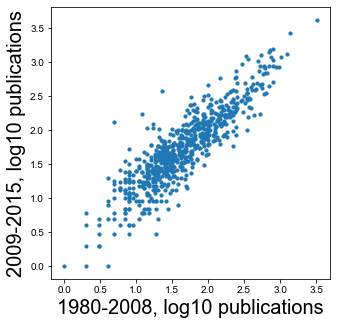

In [17]:
m = mega.copy()
m.loc[:, 'before'] = m['pubdate_year'] < 2009
m = m[['before', 'papers', 'symbol_ncbi']
        ].groupby(['before', 'symbol_ncbi']).agg(
    sum).reset_index()

h = m.pivot(index='symbol_ncbi', columns='before', values='papers')
h.columns = [str(int(x)) for x in h.columns]
h = h.rename(columns={'1': 'until 2008', '0': '2009-2015'})

plt.figure(figsize=(5, 5))

plt.scatter(
    np.log10(h.loc[:, 'until 2008']), 
    np.log10(h.loc[:, '2009-2015']), s=10)

plt.xlabel('1980-2008, log10 publications', fontsize=20)
plt.ylabel('2009-2015, log10 publications', fontsize=20)


export_image('publications')

In [18]:
h.corr('spearman')

,2009-2015,until 2008
2009-2015,1.000000,0.876801
until 2008,0.876801,1.000000


In [19]:
h.loc[:, 'is_IDH1'] = h.index.isin(
    [
        'IDH1', 
        'IDH2'
    ]
    
)

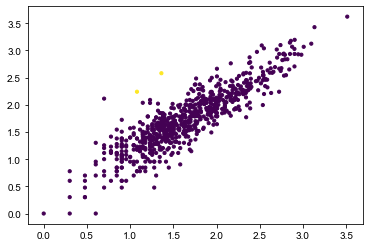

In [20]:

plt.scatter(
    np.log10(h.loc[:, 'until 2008']), 
    np.log10(h.loc[:, '2009-2015']), 
    s=10,
    c=h['is_IDH1']
)

In [21]:
h[
    (h['2009-2015']>100) &
    (h['until 2008']<10**1.5)
].sort_values('until 2008')

,2009-2015,until 2008,is_IDH1
symbol_ncbi,,,
TET2,130.0,5.0,False
IDH2,174.0,12.0,True
BAP1,109.0,14.0,False
ACKR3,123.0,17.0,False
WWTR1,108.0,17.0,False
PALB2,105.0,21.0,False
IDH1,381.0,23.0,True
FOXA1,104.0,31.0,False


In [22]:
# if save_images:
#     ret.export_full_frame('{}/inspect_paper_format.xlsx'.format(export_base), h, save_index=False)

/Users/tstoeger/opt/miniconda3/envs/recit/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':


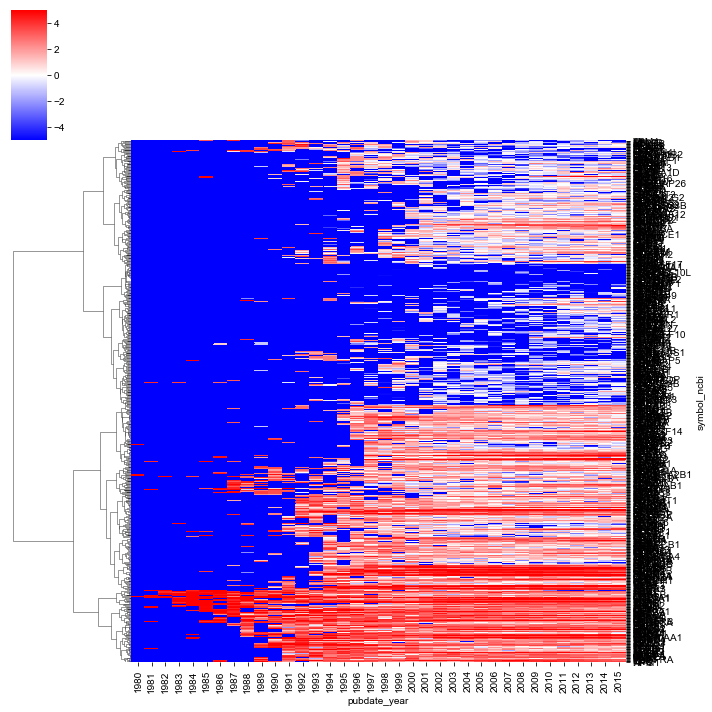

In [23]:
m = mega.copy()
m = m[['gene_ncbi', 'symbol_ncbi', 'pubdate_year', 'attention_share']]
g = m.pivot(index='symbol_ncbi', columns='pubdate_year', values='attention_share')

y= [x for x in range(1980, 2016)]
g = g.loc[:, y].fillna(0)


u = np.log2(g[y]/(1/all_gene_info.shape[0]))

u[u<-5] = -10
u[u>10] = 10

sns.clustermap(
    u, 
    col_cluster=False,
    cmap='bwr',
    method='ward',
    vmin=-5,
    vmax=5,
    yticklabels=True
)

/Users/tstoeger/opt/miniconda3/envs/recit/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2


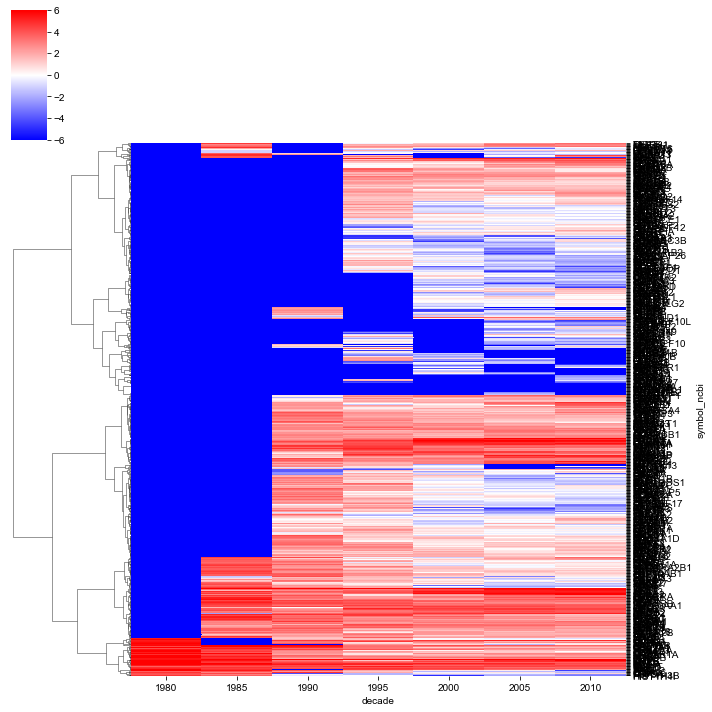

In [24]:
m = mega.copy()

y = [1980, 1985, 1990, 1995, 2000, 2005, 2010]

for yy in y:
    f = m['pubdate_year'].isin(range(yy, yy+5))
    m.loc[f, 'decade'] = yy

m = m[['gene_ncbi', 'symbol_ncbi', 'decade', 'attention_share']].groupby(
    ['gene_ncbi', 'symbol_ncbi', 'decade']
).agg(np.median).reset_index()

g = m.pivot(index='symbol_ncbi', columns='decade', values='attention_share')

g = g.loc[:, y].fillna(0)


all_gene_info.shape

u = np.log2(g[y]/(1/all_gene_info.shape[0]))

u[u<-5] = -10
u[u>10] = 10

sns.clustermap(
    u, 
    col_cluster=False,
    cmap='bwr',
    method='ward',
    vmin=-6,
    vmax=6,
    yticklabels=True
)

# export_image('share_in_years')



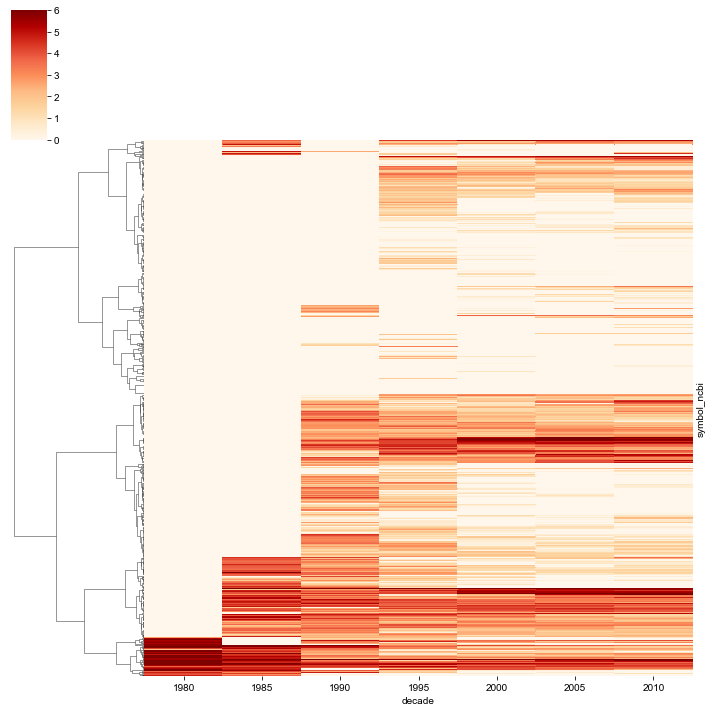

In [25]:
sns.clustermap(
    u, 
    col_cluster=False,
    cmap='OrRd',
    method='ward',
    vmin=0,
    vmax=6,
    yticklabels=False
)

export_image('share_in_years_gradual')

In [26]:
raise AssertionError('stop here')

AssertionError: stop here

In [ ]:
(u>0).any(1).mean()

In [ ]:
(u[2010]>0).mean()

In [ ]:
gm = g.copy()

In [ ]:
gm.loc[:, 'highest'] = 0

In [ ]:
for c in y:
    f = gm[c] >= gm['highest']
    gm.loc[f, 'decade'] = c
    gm.loc[f, 'highest'] = gm.loc[f, c]

In [ ]:
gm['decade'].value_counts()

In [ ]:
co = gm['decade'].value_counts() 

co/ co.sum()

In [ ]:
(co[1980] + co[1985] + co[1990] + co[1995]) / co.sum()

In [ ]:
cs = co.sort_index()

In [ ]:
cs

In [ ]:
cs / cs.sum()

In [ ]:
labels = list(cs.index)
sizes = list(cs.values)
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'blue', 'green', 'brown']
patches, texts = plt.pie(sizes, colors=colors, shadow=False, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()


# export_image('circle_annual_contribution')

In [ ]:
0.260993 

In [ ]:
m = mega.copy()

m['decade'] = m['pubdate_year'].apply(lambda x: np.floor(x/10)*10)

m = m[['gene_ncbi', 'symbol_ncbi', 'decade', 'attention_share']].groupby(
    ['gene_ncbi', 'symbol_ncbi', 'decade']
).agg(np.median).reset_index()

g = m.pivot(index='symbol_ncbi', columns='decade', values='attention_share')
g = g.loc[:, [1980, 1990, 2000, 2010]].fillna(0)

all_gene_info.shape

u = np.log2(g[[1980, 1990, 2000, 2010]]/(1/all_gene_info.shape[0]))

u[u<-5] = -10
u[u>10] = 10

sns.clustermap(
    u, 
    col_cluster=False,
    cmap='bwr',
    method='ward',
    vmin=-5,
    vmax=5,
    yticklabels=True
)

In [ ]:
sns.clustermap(
    g[[1980, 1990, 2000, 2010]].apply(lambda x: np.log10(x+0.00001)), 
    col_cluster=False,
    cmap='OrRd',
    method='ward')
 
